In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
FOLDERNAME='Assignment4'
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
!pip install wandb torch torchvision matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import wandb
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
import helpers.data_loader as data_loader
train_loader, val_loader, test_df=data_loader.get_complete_fer_setup()

In [5]:
wandb.login()
results = {}
models={}

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: skara21 (skara21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
import helpers.model_train as model_train
import helpers.model_analyser as model_analyser

In [7]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=True)
            )

    def forward(self, x):
        identity = self.shortcut(x)

        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += identity
        out = F.relu(out)

        return out

In [8]:
class StandardCNN6Layer(nn.Module):
    def __init__(self, num_classes=7):
        super(StandardCNN6Layer, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))

        x = F.relu(self.conv5(x))
        x = self.pool3(F.relu(self.conv6(x)))

        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


🔬 EXPERIMENT 1/4: Standard 6-Layer CNN


Epoch  0: Train: 26.2%, Val: 29.1%, Gap: -0.049
Epoch  5: Train: 60.5%, Val: 56.5%, Gap: 0.110
Epoch 10: Train: 85.4%, Val: 58.0%, Gap: 1.263
Early stopping at epoch 14


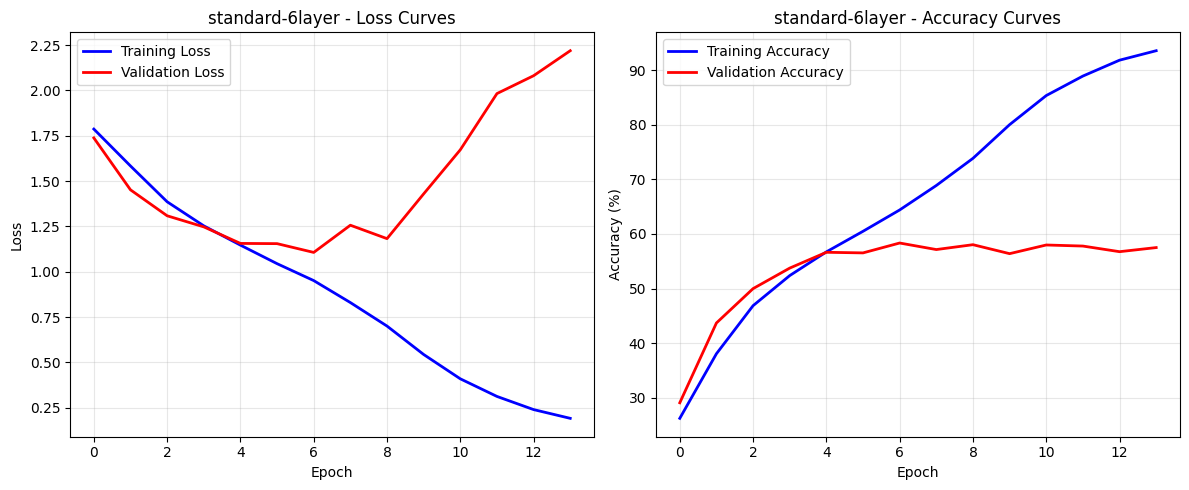

accuracy_gap,▁▁▃▆█
epoch,▁▃▅▆█
final/best_val_accuracy,▁
final/final_acc_gap,▁
final/final_loss_gap,▁
final/final_train_accuracy,▁
final/final_val_accuracy,▁
final/overfitting_score,▁
final/total_epochs,▁
final/total_parameters,▁
learning_rate,▁▄▇█▇


In [9]:
print("\n🔬 EXPERIMENT 1/4: Standard 6-Layer CNN")

model_standard = StandardCNN6Layer(num_classes=7)
results_standard = model_train.train_model_connections(
    model=model_standard,
    train_loader=train_loader,
    val_loader=val_loader,
    experiment_name="standard-6layer",
    device=device,
    epochs=30
)
results['standard'] = results_standard
models['standard'] = model_standard

In [10]:
class SkipConnectionsCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SkipConnectionsCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=True)

        self.layer1 = self._make_layer(32, 32, 2, stride=1)
        self.layer2 = self._make_layer(32, 64, 2, stride=2)
        self.layer3 = self._make_layer(64, 128, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        x = self.layer1(x)
        x = F.max_pool2d(x, 2)

        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


🔬 EXPERIMENT 2/4: Skip Connections CNN


Epoch  0: Train: 24.9%, Val: 25.0%, Gap: -0.016
Epoch  5: Train: 55.1%, Val: 55.3%, Gap: -0.017
Epoch 10: Train: 68.7%, Val: 58.7%, Gap: 0.301
Epoch 15: Train: 85.8%, Val: 58.8%, Gap: 1.242
Epoch 20: Train: 98.1%, Val: 59.7%, Gap: 2.852
Epoch 25: Train: 99.8%, Val: 60.5%, Gap: 3.547
Epoch 29: Train: 99.8%, Val: 60.5%, Gap: 3.787


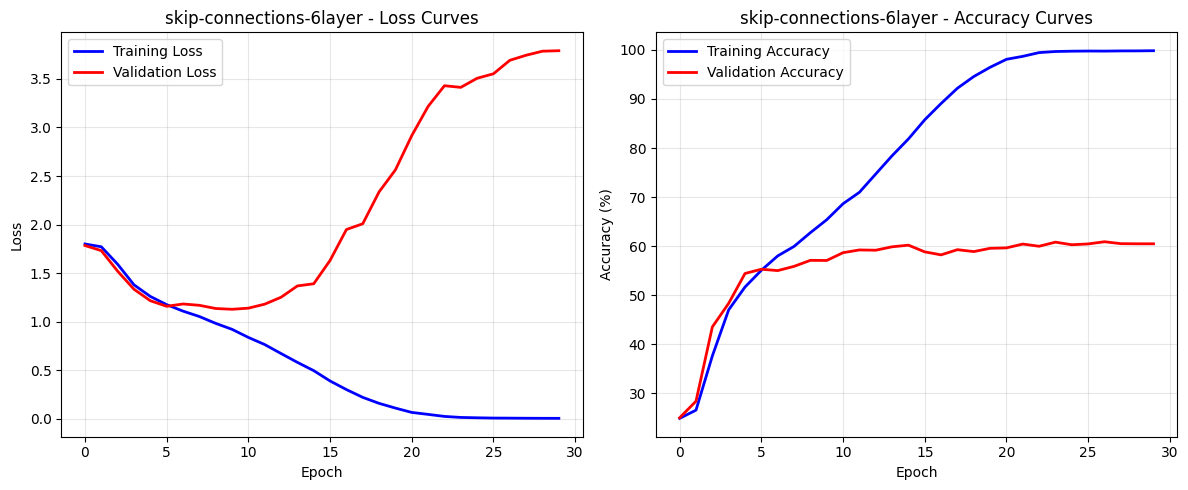

accuracy_gap,▁▁▂▃▄▆▇████
epoch,▁▂▂▃▄▅▅▆▇██
final/best_val_accuracy,▁
final/final_acc_gap,▁
final/final_loss_gap,▁
final/final_train_accuracy,▁
final/final_val_accuracy,▁
final/overfitting_score,▁
final/total_epochs,▁
final/total_parameters,▁
learning_rate,▁▄▇█▇▆▅▃▂▁▁


In [11]:
print("\n🔬 EXPERIMENT 2/4: Skip Connections CNN")

model_skip = SkipConnectionsCNN(num_classes=7)
results_skip = model_train.train_model_connections(
    model=model_skip,
    train_loader=train_loader,
    val_loader=val_loader,
    experiment_name="skip-connections-6layer",
    device=device,
    epochs=30
)
results['skip_connections'] = results_skip
models['skip_connections'] = model_skip

In [12]:
class HybridSkipCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(HybridSkipCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.resblock1 = ResNetBlock(32, 64, stride=1)
        self.resblock2 = ResNetBlock(64, 64, stride=1)
        self.resblock3 = ResNetBlock(64, 128, stride=1)
        self.resblock4 = ResNetBlock(128, 128, stride=1)

        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.pool2(x)

        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.pool3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


🔬 EXPERIMENT 3/4: Hybrid Skip Connections CNN


Epoch  0: Train: 24.8%, Val: 24.9%, Gap: -0.009
Epoch  5: Train: 53.4%, Val: 55.4%, Gap: -0.048
Epoch 10: Train: 66.8%, Val: 61.7%, Gap: 0.183
Epoch 15: Train: 82.9%, Val: 60.8%, Gap: 0.839
Epoch 20: Train: 97.9%, Val: 62.7%, Gap: 2.490
Epoch 25: Train: 99.7%, Val: 63.8%, Gap: 2.956
Epoch 29: Train: 99.8%, Val: 63.5%, Gap: 3.080


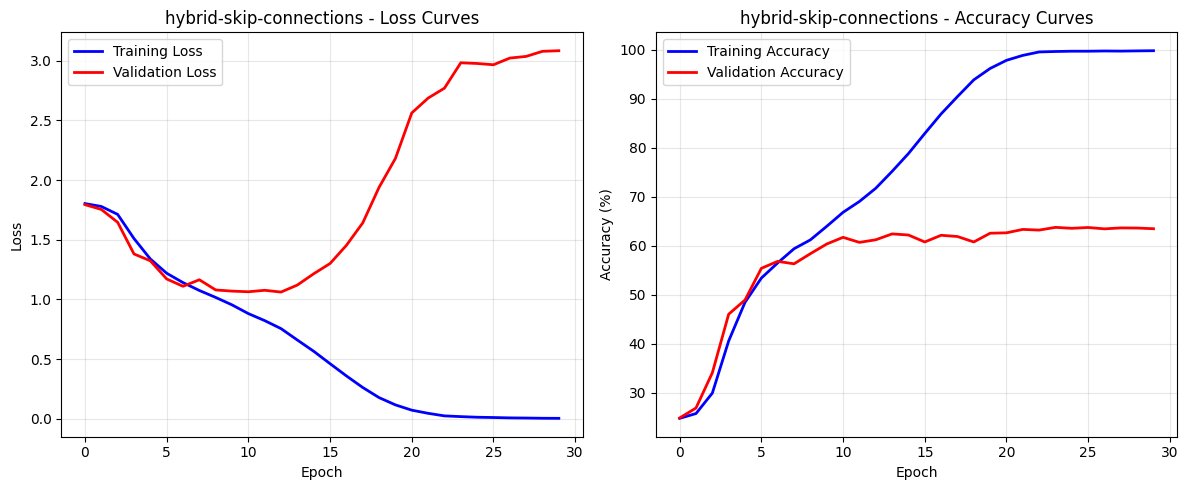

accuracy_gap,▂▁▂▃▄▆▇████
epoch,▁▂▂▃▄▅▅▆▇██
final/best_val_accuracy,▁
final/final_acc_gap,▁
final/final_loss_gap,▁
final/final_train_accuracy,▁
final/final_val_accuracy,▁
final/overfitting_score,▁
final/total_epochs,▁
final/total_parameters,▁
learning_rate,▁▄▇█▇▆▅▃▂▁▁


In [13]:
print("\n🔬 EXPERIMENT 3/4: Hybrid Skip Connections CNN")

model_hybrid = HybridSkipCNN(num_classes=7)
results_hybrid = model_train.train_model_connections(
    model=model_hybrid,
    train_loader=train_loader,
    val_loader=val_loader,
    experiment_name="hybrid-skip-connections",
    device=device,
    epochs=30
)
results['hybrid'] = results_hybrid
models['hybrid'] = model_hybrid

In [14]:
class DenseConnectionsCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(DenseConnectionsCNN, self).__init__()

        self.conv0 = nn.Conv2d(1, 32, kernel_size=3, padding=1)

        self.conv1_1 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(96, 32, kernel_size=3, padding=1)

        self.trans1 = nn.Conv2d(96, 64, kernel_size=1)
        self.trans2 = nn.Conv2d(128, 128, kernel_size=1)

        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)


    def forward(self, x):
        x0 = F.relu(self.conv0(x))

        x1_1 = F.relu(self.conv1_1(x0))
        x1_cat = torch.cat([x0, x1_1], 1)
        x1_2 = F.relu(self.conv1_2(x1_cat))

        x1_final = torch.cat([x0, x1_1, x1_2], 1)
        x1_trans = F.relu(self.trans1(x1_final))
        x1_pool = self.pool1(x1_trans)

        x2_1 = F.relu(self.conv2_1(x1_pool))
        x2_cat = torch.cat([x1_pool, x2_1], 1)
        x2_2 = F.relu(self.conv2_2(x2_cat))

        x2_final = torch.cat([x1_pool, x2_1, x2_2], 1)
        x2_trans = F.relu(self.trans2(x2_final))

        x = self.pool3(x2_trans)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


🔬 EXPERIMENT 4/4: Dense Connections CNN


Epoch  0: Train: 24.9%, Val: 24.5%, Gap: -0.030
Epoch  5: Train: 31.7%, Val: 32.2%, Gap: -0.020
Epoch 10: Train: 49.3%, Val: 48.0%, Gap: 0.020
Epoch 15: Train: 57.0%, Val: 52.9%, Gap: 0.090
Epoch 20: Train: 63.3%, Val: 54.7%, Gap: 0.209
Epoch 25: Train: 68.3%, Val: 56.5%, Gap: 0.332
Epoch 29: Train: 69.8%, Val: 56.7%, Gap: 0.374


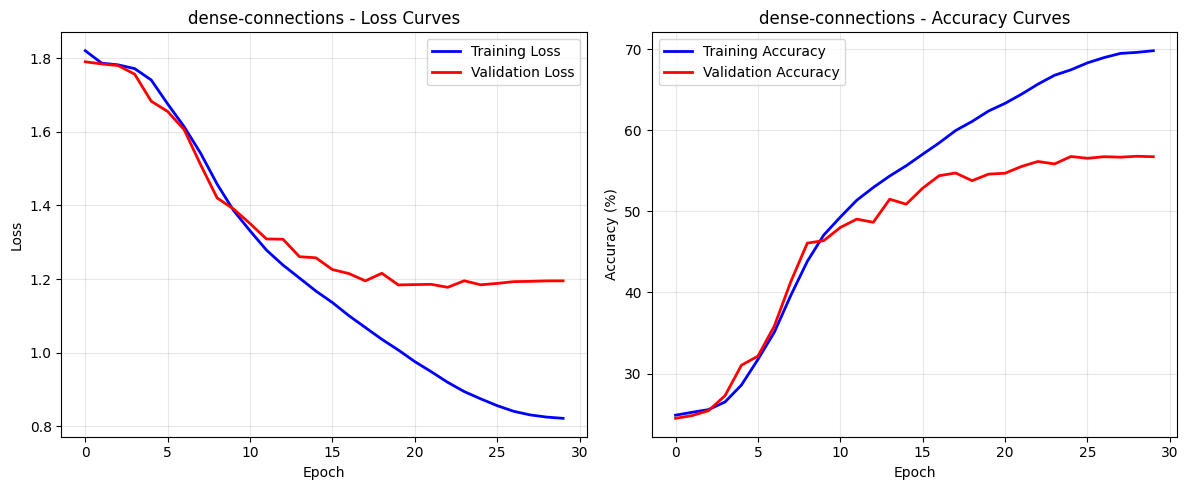

accuracy_gap,▂▁▁▂▄▄▅▆▇██
epoch,▁▂▂▃▄▅▅▆▇██
final/best_val_accuracy,▁
final/final_acc_gap,▁
final/final_loss_gap,▁
final/final_train_accuracy,▁
final/final_val_accuracy,▁
final/overfitting_score,▁
final/total_epochs,▁
final/total_parameters,▁
learning_rate,▁▄▇█▇▆▅▃▂▁▁


In [15]:
print("\n🔬 EXPERIMENT 4/4: Dense Connections CNN")

model_dense = DenseConnectionsCNN(num_classes=7)
results_dense = model_train.train_model_connections(
    model=model_dense,
    train_loader=train_loader,
    val_loader=val_loader,
    experiment_name="dense-connections",
    device=device,
    epochs=30
)
results['dense'] = results_dense
models['dense'] = model_dense

გავაანალიზოთ მიღებული შედეგი

In [16]:
print("Analyzing results: ")

results_df=pd.DataFrame([
    {
        'Architecture': arch.replace('_', ' ').title(),
        'Parameters': result['total_parameters'],
        'Best_Val_Acc': result['best_val_accuracy'],
        'Final_Train_Acc': result['final_train_accuracy'],
        'Final_Val_Acc': result['final_val_accuracy'],
        'Acc_Gap': result['final_train_accuracy'] - result['final_val_accuracy'],
        'Loss_Gap': result['final_loss_gap'],
        'Status': result['model_status'],
        'Epochs': result['total_epochs']
    }
    for arch, result in results.items()
])


print(results_df.to_string(index=False, float_format='%.2f'))


baseline_acc_gap = results['standard']['final_train_accuracy'] - results['standard']['final_val_accuracy']
baseline_loss_gap = results['standard']['final_loss_gap']
baseline_key = 'standard'


for arch, result in results.items():
    if arch == baseline_key:
        continue

    current_acc_gap = result['final_train_accuracy'] - result['final_val_accuracy']
    current_loss_gap = result['final_loss_gap']

    acc_improvement = baseline_acc_gap - current_acc_gap
    loss_improvement = baseline_loss_gap - current_loss_gap
    val_acc_improvement = result['final_val_accuracy'] - results[baseline_key]['final_val_accuracy']

    print(f"\n{arch.upper()} vs {baseline_key.upper()}:")
    print(f"  Accuracy Gap: {current_acc_gap:.1f}% vs {baseline_acc_gap:.1f}% (Δ{acc_improvement:+.1f}%)")
    print(f"  Loss Gap: {current_loss_gap:.3f} vs {baseline_loss_gap:.3f} (Δ{loss_improvement:+.3f})")
    print(f"  Val Accuracy: {result['final_val_accuracy']:.1f}% vs {results[baseline_key]['final_val_accuracy']:.1f}% (Δ{val_acc_improvement:+.1f}%)")

    if acc_improvement > 5 and loss_improvement > 0.1:
        effectiveness = "HIGHLY"
    elif acc_improvement > 2 and loss_improvement > 0.05:
        effectiveness = "MODERATELY"
    elif acc_improvement > 0:
        effectiveness = "SLIGHTLY"
    else:
        effectiveness = "NOT"

    print(f"  Overall: {effectiveness} effective")

Analyzing results: 
    Architecture  Parameters  Best_Val_Acc  Final_Train_Acc  Final_Val_Acc  Acc_Gap  Loss_Gap       Status  Epochs
        Standard     2649831         58.34            93.59          57.51    36.09     -2.03  OVERFITTING      14
Skip Connections      694535         60.91            99.82          60.49    39.33     -3.79  OVERFITTING      30
          Hybrid      666791         63.78            99.83          63.50    36.33     -3.08  OVERFITTING      30
           Dense       97799         56.78            69.79          56.73    13.06     -0.37 GOOD_BALANCE      30

SKIP_CONNECTIONS vs STANDARD:
  Accuracy Gap: 39.3% vs 36.1% (Δ-3.2%)
  Loss Gap: -3.787 vs -2.028 (Δ+1.760)
  Val Accuracy: 60.5% vs 57.5% (Δ+3.0%)
  Overall: NOT effective

HYBRID vs STANDARD:
  Accuracy Gap: 36.3% vs 36.1% (Δ-0.2%)
  Loss Gap: -3.080 vs -2.028 (Δ+1.053)
  Val Accuracy: 63.5% vs 57.5% (Δ+6.0%)
  Overall: NOT effective

DENSE vs STANDARD:
  Accuracy Gap: 13.1% vs 36.1% (Δ+23.0%)
  Lo

Visualization:


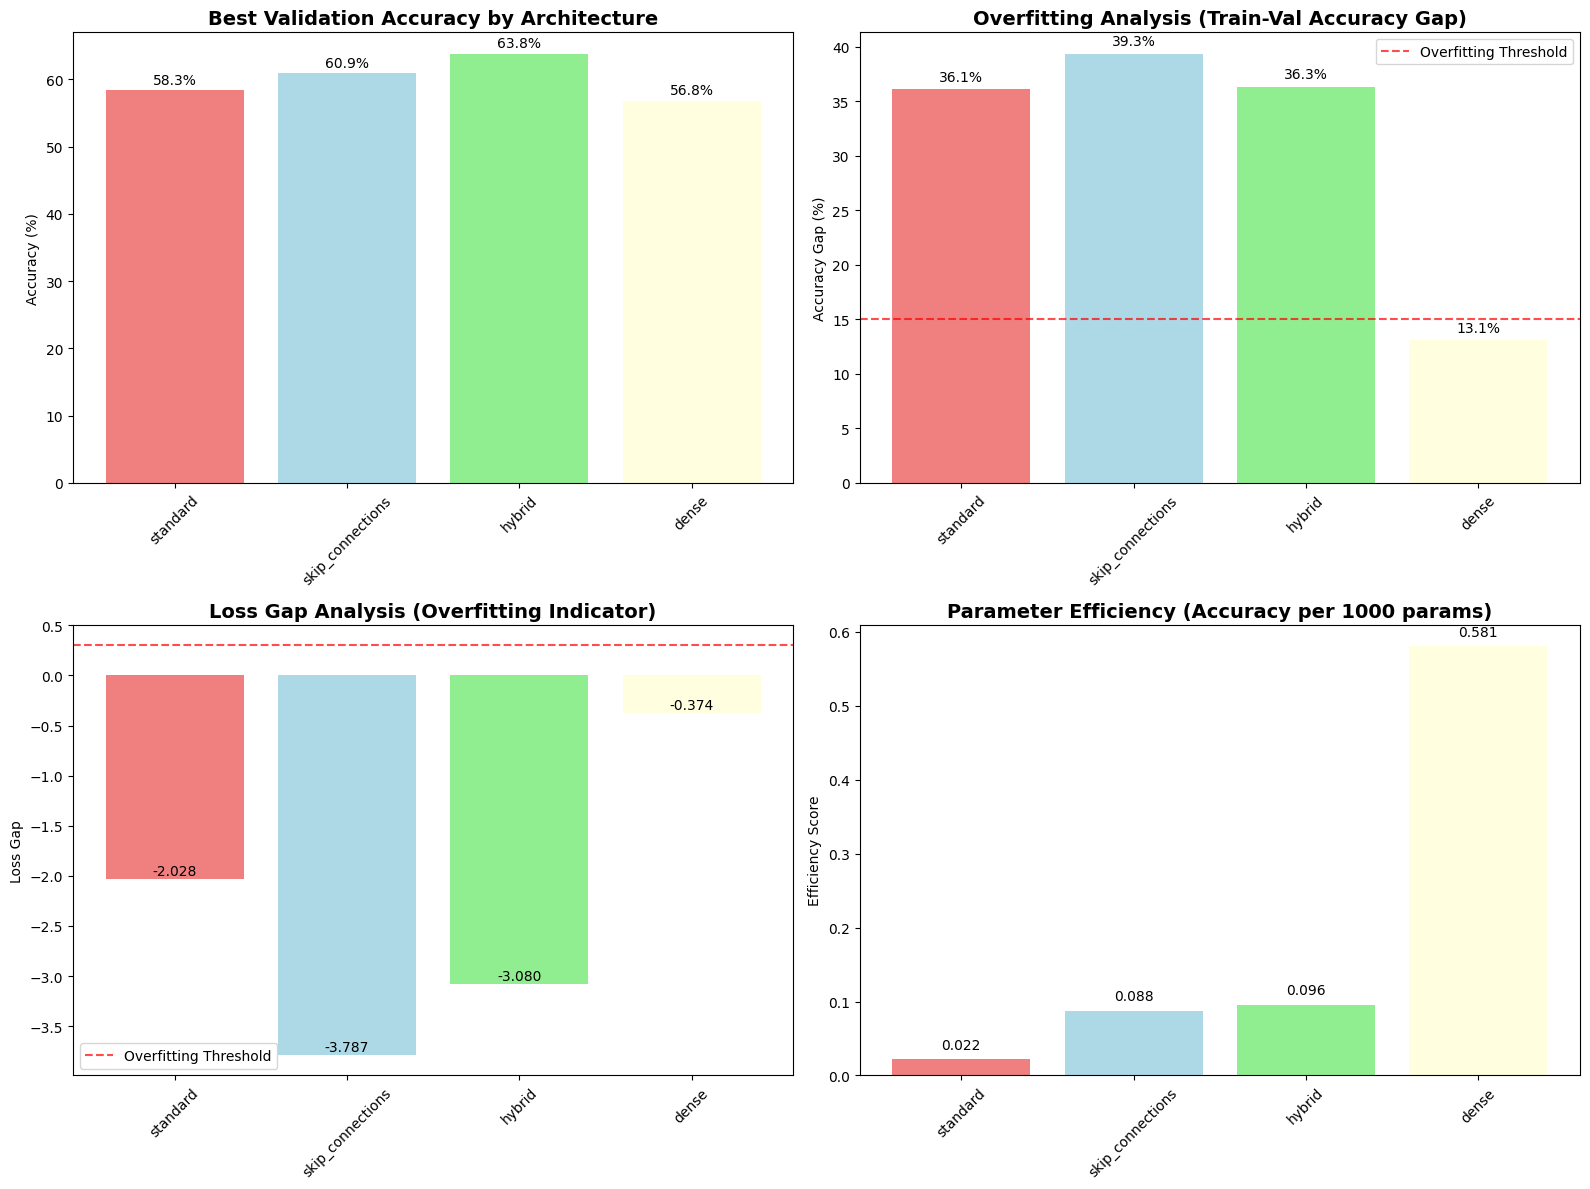

In [17]:
print("Visualization:")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

architectures = list(results.keys())
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'][:len(architectures)]

# 1. Validation Accuracy Comparison
val_accs = [results[arch]['best_val_accuracy'] for arch in architectures]
bars1 = ax1.bar(architectures, val_accs, color=colors)
ax1.set_title('Best Validation Accuracy by Architecture', fontweight='bold', fontsize=14)
ax1.set_ylabel('Accuracy (%)')
ax1.tick_params(axis='x', rotation=45)
for bar, acc in zip(bars1, val_accs):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
              f'{acc:.1f}%', ha='center', va='bottom')

# 2. Overfitting Comparison (Accuracy Gap)
acc_gaps = [results[arch]['final_train_accuracy'] - results[arch]['final_val_accuracy']
            for arch in architectures]
bars2 = ax2.bar(architectures, acc_gaps, color=colors)
ax2.set_title('Overfitting Analysis (Train-Val Accuracy Gap)', fontweight='bold', fontsize=14)
ax2.set_ylabel('Accuracy Gap (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=15, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
ax2.legend()
for bar, gap in zip(bars2, acc_gaps):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
              f'{gap:.1f}%', ha='center', va='bottom')

# 3. Loss Gap Comparison
loss_gaps = [results[arch]['final_loss_gap'] for arch in architectures]
bars3 = ax3.bar(architectures, loss_gaps, color=colors)
ax3.set_title('Loss Gap Analysis (Overfitting Indicator)', fontweight='bold', fontsize=14)
ax3.set_ylabel('Loss Gap')
ax3.tick_params(axis='x', rotation=45)
ax3.axhline(y=0.3, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
ax3.legend()
for bar, gap in zip(bars3, loss_gaps):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
              f'{gap:.3f}', ha='center', va='bottom')

# 4. Parameter Efficiency (Accuracy per 1000 parameters)
params = [results[arch]['total_parameters']/1000 for arch in architectures]
efficiency = [val_acc/param for val_acc, param in zip(val_accs, params)]
bars4 = ax4.bar(architectures, efficiency, color=colors)
ax4.set_title('Parameter Efficiency (Accuracy per 1000 params)', fontweight='bold', fontsize=14)
ax4.set_ylabel('Efficiency Score')
ax4.tick_params(axis='x', rotation=45)
for bar, eff in zip(bars4, efficiency):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
              f'{eff:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [18]:
print("Final reccomendation:")

best_arch = max(results.keys(), key=lambda x: results[x]['best_val_accuracy'])
least_overfitted = min(results.keys(), key=lambda x: results[x]['final_train_accuracy'] - results[x]['final_val_accuracy'])

print(f"Best performing: {best_arch} ({results[best_arch]['best_val_accuracy']:.2f}%)")
print(f"Least overfitted: {least_overfitted} (gap: {results[least_overfitted]['final_train_accuracy'] - results[least_overfitted]['final_val_accuracy']:.1f}%)")

print(f"Use {best_arch} architecture as baseline for advanced architectures study")

print(f"Highest validation accuracy: {results[best_arch]['best_val_accuracy']:.2f}%")
print(f"Training-validation gap: {results[best_arch]['final_train_accuracy'] - results[best_arch]['final_val_accuracy']:.1f}%")
print(f"Total parameters: {results[best_arch]['total_parameters']:,}")

Final reccomendation:
Best performing: hybrid (63.78%)
Least overfitted: dense (gap: 13.1%)
Use hybrid architecture as baseline for advanced architectures study
Highest validation accuracy: 63.78%
Training-validation gap: 36.3%
Total parameters: 666,791
